In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
import os

import geopandas as gpd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib import merge_in_geometry
from plot import map_outage

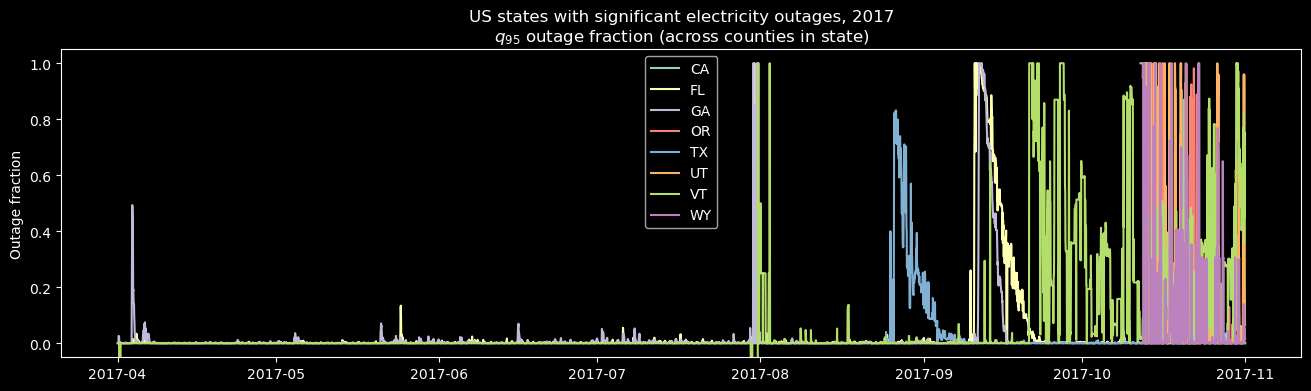

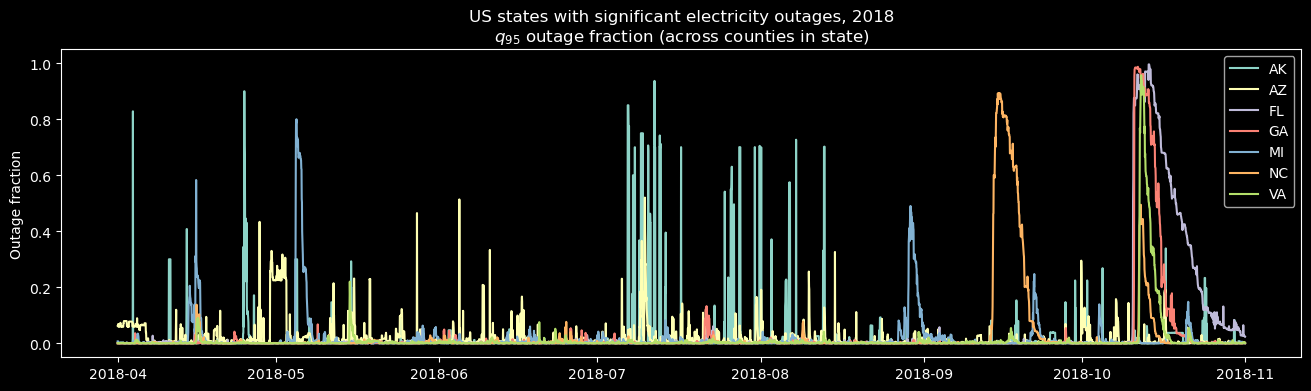

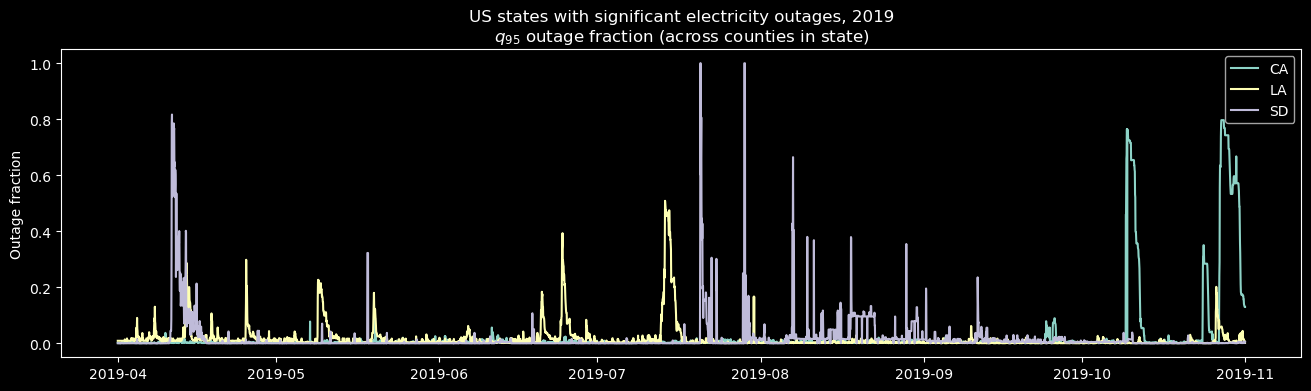

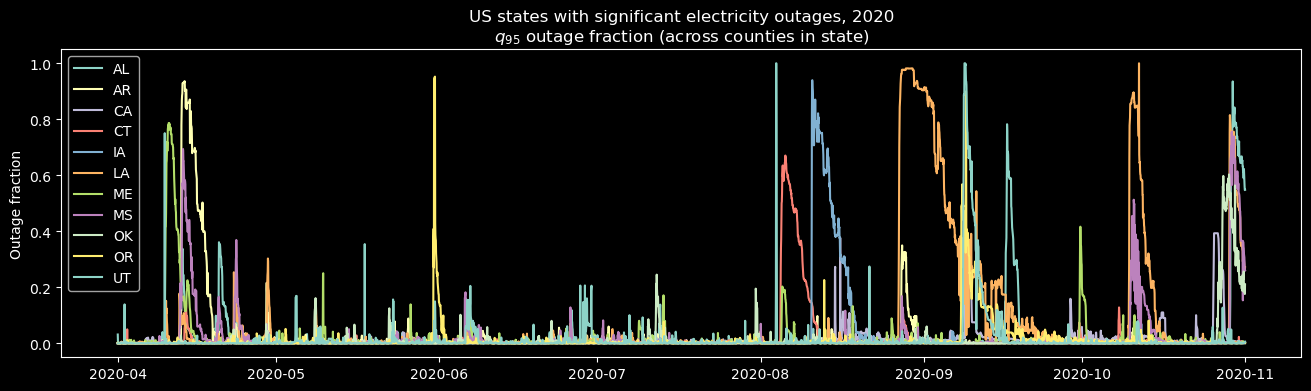

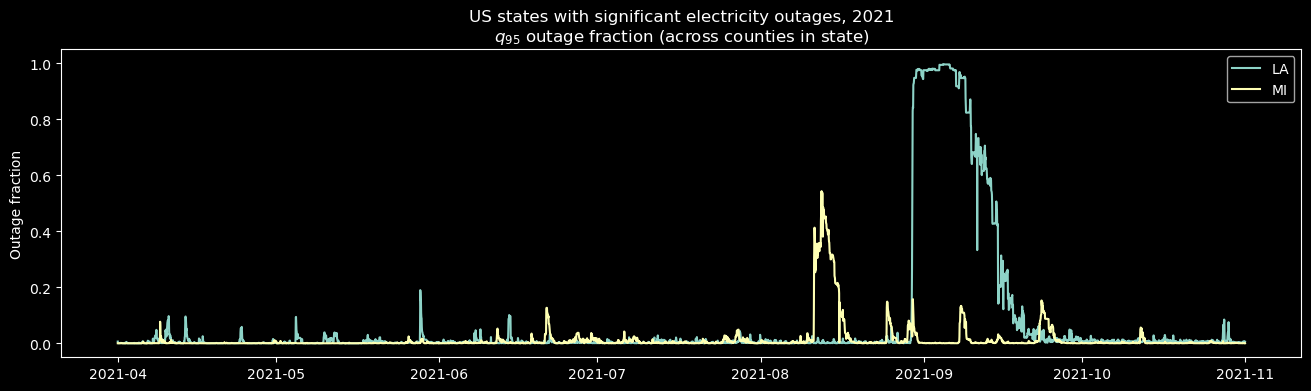

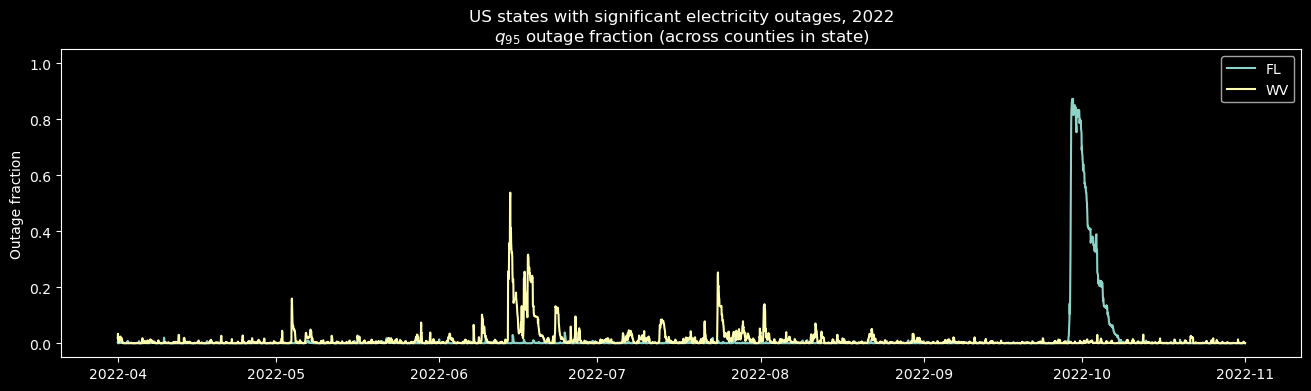

In [10]:
plt.style.use('dark_background')  # for cool points

years = list(range(2017, 2023))
root_dir = "data"
states = pd.read_csv(os.path.join(root_dir, "raw/states/state_codes.csv")).set_index("state_fips_code")
county_boundaries: gpd.GeoDataFrame = gpd.read_file(os.path.join(root_dir, "raw/counties/cb_2018_us_county_500k.shp"))

for year in years:
    processed_path = os.path.join(root_dir, f"processed/outage/{year}.parquet")
    data = pd.read_parquet(processed_path)

    outage = merge_in_geometry(data, county_boundaries)
    outage["STATEFP"] = outage.STATEFP.astype(int)
    outage = outage.reset_index().set_index(["RecordDateTime", "STATEFP", "CountyFIPS"])
    grp_by = outage.loc[:, ["OutageFraction"]].groupby(level=["RecordDateTime", "STATEFP"]).quantile(0.95)

    f, ax = plt.subplots(figsize=(16,4))

    for state_code in set(grp_by.index.get_level_values("STATEFP")):

        timeseries = grp_by.loc[(slice(None), state_code), :].reset_index().set_index("RecordDateTime").loc[:, ["OutageFraction"]]

        # a fairly arbitrary measure of the number and magnitude of outages in the state that year
        quantile_sum = timeseries.sum().iloc[0]  

        # if this state has been particularly badly hit this year, plot it
        if quantile_sum > 60:
            try:
                ax.plot(timeseries.index, timeseries.OutageFraction, label=states.loc[state_code, "state_alpha_2_code"])
            except KeyError:
                continue

    ax.legend()
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Outage fraction")
    ax.set_title(
        f"US states with significant electricity outages, {year}\n"
        "$q_{{95}}$ outage fraction (across counties in state)"
    )
    f.savefig(f"outages_by_state_{year}.png")